In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

In [2]:
from pyspark.sql.functions import when, count, col, log, avg, array, explode, struct, lit
from pyspark.sql.types import StructField,StringType,IntegerType,StructType

from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer,Normalizer
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Use Spark to read csv file
SuicideStats = spark.read.csv("data/who_suicide_statistics.csv",inferSchema=True,header=True)

HDIStats = spark.read.csv("data/Human Development Index.csv",inferSchema=True,header=True)

WDIStats = spark.read.csv("data/World_Development_Indicators.csv",inferSchema=True,header=True)

In [4]:
#Data Exploration

#Explore the volumn of the dataset WHO Suicide Statistics
print((SuicideStats.count(), len(SuicideStats.columns)))

(43776, 6)


In [5]:
#Explore the volumn of the dataset Human Development Index
print((HDIStats.count(), len(HDIStats.columns)))

(189, 31)


In [6]:
#Explore the volumn of the dataset World Development Indicators
print((WDIStats.count(), len(WDIStats.columns)))

(6944, 6)


In [7]:
#Explore the data quality of the dataset WHO Suicide Statistics
print(SuicideStats.columns)
SuicideStats.show(6)

['country', 'year', 'sex', 'age', 'suicides_no', 'population']
+-------+----+------+-----------+-----------+----------+
|country|year|   sex|        age|suicides_no|population|
+-------+----+------+-----------+-----------+----------+
|Albania|1985|female|15-24 years|       null|    277900|
|Albania|1985|female|25-34 years|       null|    246800|
|Albania|1985|female|35-54 years|       null|    267500|
|Albania|1985|female| 5-14 years|       null|    298300|
|Albania|1985|female|55-74 years|       null|    138700|
|Albania|1985|female|  75+ years|       null|     34200|
+-------+----+------+-----------+-----------+----------+
only showing top 6 rows



In [8]:
#Explore the data type of the dataset WHO Suicide Statistics
SuicideStats.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)



In [9]:
SuicideStats.select("sex").distinct().show()
SuicideStats.select("age").distinct().show()
print(SuicideStats.select("country").distinct().count())
SuicideStats.select("country").distinct().show(6)

+------+
|   sex|
+------+
|female|
|  male|
+------+

+-----------+
|        age|
+-----------+
|55-74 years|
|25-34 years|
| 5-14 years|
|  75+ years|
|15-24 years|
|35-54 years|
+-----------+

141
+-----------------+
|          country|
+-----------------+
|         Anguilla|
|         Paraguay|
|       Cabo Verde|
|           Sweden|
|         Kiribati|
|Republic of Korea|
+-----------------+
only showing top 6 rows



In [10]:
#Explore the general statistics of the dataset WHO Suicide Statistics
SuicideStats.describe().show()

+-------+--------+------------------+------+-----------+-----------------+------------------+
|summary| country|              year|   sex|        age|      suicides_no|        population|
+-------+--------+------------------+------+-----------+-----------------+------------------+
|  count|   43776|             43776| 43776|      43776|            41520|             38316|
|   mean|    null|1998.5024671052631|  null|       null|193.3153901734104|1664091.1353742562|
| stddev|    null|10.338711176746282|  null|       null|800.5899259349637|3647231.2274873867|
|    min| Albania|              1979|female|15-24 years|                0|               259|
|    max|Zimbabwe|              2016|  male|  75+ years|            22338|          43805214|
+-------+--------+------------------+------+-----------+-----------------+------------------+



In [11]:
#Explore the data quality of the dataset Human Development Index
print(HDIStats.columns)
HDIStats.show(6)

['HDI Rank', 'Country', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
+--------+-----------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|HDI Rank|          Country| 1990| 1991| 1992| 1993| 1994| 1995| 1996| 1997| 1998| 1999| 2000| 2001| 2002| 2003| 2004| 2005| 2006| 2007| 2008| 2009| 2010| 2011| 2012| 2013| 2014| 2015| 2016| 2017| 2018|
+--------+-----------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|     170|      Afghanistan|0.298|0.304|0.312|0.308|0.303|0.327|0.331|0.335|0.339|0.343|0.345|0.347|0.378|0.387|  0.4| 0.41|0.419|0.431

In [12]:
#Explore the data type of the dataset Human Development Index
HDIStats.printSchema()

root
 |-- HDI Rank: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- 1990: string (nullable = true)
 |-- 1991: string (nullable = true)
 |-- 1992: string (nullable = true)
 |-- 1993: string (nullable = true)
 |-- 1994: string (nullable = true)
 |-- 1995: string (nullable = true)
 |-- 1996: string (nullable = true)
 |-- 1997: string (nullable = true)
 |-- 1998: string (nullable = true)
 |-- 1999: string (nullable = true)
 |-- 2000: string (nullable = true)
 |-- 2001: string (nullable = true)
 |-- 2002: string (nullable = true)
 |-- 2003: string (nullable = true)
 |-- 2004: string (nullable = true)
 |-- 2005: string (nullable = true)
 |-- 2006: string (nullable = true)
 |-- 2007: string (nullable = true)
 |-- 2008: string (nullable = true)
 |-- 2009: string (nullable = true)
 |-- 2010: string (nullable = true)
 |-- 2011: string (nullable = true)
 |-- 2012: string (nullable = true)
 |-- 2013: string (nullable = true)
 |-- 2014: string (nullable = true)
 |-- 2015: stri

In [13]:
#Explore the general statistics of the dataset Human Development Index
HDIStats.describe().show()

+-------+-----------------+-----------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+-----------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+
|summary|         HDI Rank|    Country|               1990|              1991|               1992|               1993|               1994|              1995|               1996|              1997|              1998|             1999|               2000|               2001|               2002|              2003|               2004|               2005|              2006|               2007|

In [14]:
#Explore the data quality of the dataset World Development Indicators
print(WDIStats.columns)
WDIStats.show(6)

['Country Name', 'Year', 'Employment to population ratio', 'GDP', 'GDP per capita', 'Gini index']
+------------+----+------------------------------+----+--------------+----------+
|Country Name|Year|Employment to population ratio| GDP|GDP per capita|Gini index|
+------------+----+------------------------------+----+--------------+----------+
| Afghanistan|1985|                          null|null|          null|      null|
| Afghanistan|1986|                          null|null|          null|      null|
| Afghanistan|1987|                          null|null|          null|      null|
| Afghanistan|1988|                          null|null|          null|      null|
| Afghanistan|1989|                          null|null|          null|      null|
| Afghanistan|1990|                          null|null|          null|      null|
+------------+----+------------------------------+----+--------------+----------+
only showing top 6 rows



In [15]:
#Explore the data type of the dataset World Development Indicators
WDIStats.printSchema()

root
 |-- Country Name: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Employment to population ratio: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- GDP per capita: double (nullable = true)
 |-- Gini index: double (nullable = true)



In [16]:
#Explore the general statistics of the dataset World Development Indicators
WDIStats.describe().show()

+-------+------------+-----------------+------------------------------+--------------------+------------------+-----------------+
|summary|Country Name|             Year|Employment to population ratio|                 GDP|    GDP per capita|       Gini index|
+-------+------------+-----------------+------------------------------+--------------------+------------------+-----------------+
|  count|        6944|             6944|                          4862|                5979|              5976|             1550|
|   mean|        null|           2000.5|              57.6225362242226|2.745890309848958...| 13124.04119241654|38.62148387096775|
| stddev|        null|9.233757553344075|            11.968146617150545|1.111967617317697E12|20099.670239668914|9.432100956926329|
|    min| Afghanistan|             1985|                   26.32999992|       2.144196696E7|       164.1918663|             20.2|
|    max|    Zimbabwe|             2016|                    90.4469986|          1.69723E1

In [17]:
#Explore missing values in the dataset WHO Suicide Statistics

SuicideStats.select([count(when(col(c).isNull(), c)).alias(c) for c in SuicideStats.columns]).show()
SuicideStats.describe().filter(col("summary")  == "count").show()

+-------+----+---+---+-----------+----------+
|country|year|sex|age|suicides_no|population|
+-------+----+---+---+-----------+----------+
|      0|   0|  0|  0|       2256|      5460|
+-------+----+---+---+-----------+----------+

+-------+-------+-----+-----+-----+-----------+----------+
|summary|country| year|  sex|  age|suicides_no|population|
+-------+-------+-----+-----+-----+-----------+----------+
|  count|  43776|43776|43776|43776|      41520|     38316|
+-------+-------+-----+-----+-----+-----------+----------+



In [18]:
#Re-import dataset, taking .. as null value
HDIStats = spark.read.csv("data/Human Development Index.csv",inferSchema=True, header=True, nullValue="..")

#Explore missing values in the dataset World Development Indicators
HDIStats.select([count(when(col(c).isNull(), c)).alias(c) for c in HDIStats.columns]).show()
HDIStats.describe().filter(col("summary")  == "count").show()

+--------+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|HDI Rank|Country|1990|1991|1992|1993|1994|1995|1996|1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|
+--------+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|       0|      0|  45|  45|  46|  45|  45|  41|  41|  42|  41|  38|  15|  15|  14|  12|  10|   3|   3|   3|   3|   3|   1|   1|   1|   1|   1|   1|   1|   0|   0|
+--------+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+

+-------+--------+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|summar

In [19]:
#Explore missing values in the dataset World Development Indicators
WDIStats.select([count(when(col(c).isNull(), c)).alias(c) for c in WDIStats.columns]).show()
WDIStats.describe().filter(col("summary")  == "count").show()

+------------+----+------------------------------+---+--------------+----------+
|Country Name|Year|Employment to population ratio|GDP|GDP per capita|Gini index|
+------------+----+------------------------------+---+--------------+----------+
|           0|   0|                          2082|965|           968|      5394|
+------------+----+------------------------------+---+--------------+----------+

+-------+------------+----+------------------------------+----+--------------+----------+
|summary|Country Name|Year|Employment to population ratio| GDP|GDP per capita|Gini index|
+-------+------------+----+------------------------------+----+--------------+----------+
|  count|        6944|6944|                          4862|5979|          5976|      1550|
+-------+------------+----+------------------------------+----+--------------+----------+



In [20]:


#Explore the extreme values and outliers of the dataset WHO Suicide Statistics

SuicideStats.write.mode("overwrite").csv('ModelDataSource.csv')

SuicideStats_pd = pd.read_csv("ModelDataSource.csv")


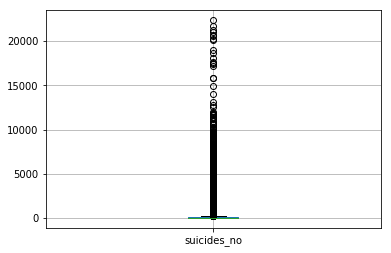

In [21]:
SuicideStats_pd.boxplot(column=['suicides_no'])

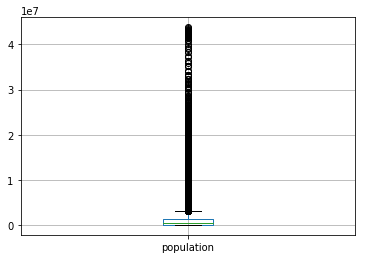

In [22]:
SuicideStats_pd.boxplot(column=['population'])

In [23]:
#Explore the extreme values and outliers of the dataset Human Development Index
HDIStats.write.mode("overwrite").csv('ModelDataSource.csv')
HDIStats_pd = pd.read_csv("ModelDataSource.csv")


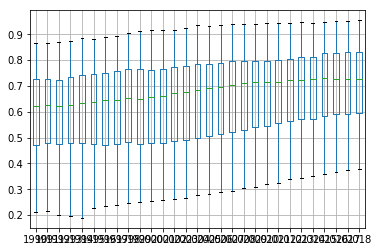

In [24]:
columns = HDIStats.columns
columns.remove('Country')
columns.remove('HDI Rank')

HDIStats_pd.boxplot(column=columns)

In [25]:
#Explore the extreme values and outliers of the dataset World Development Indicators
WDIStats.write.mode("overwrite").csv('ModelDataSource.csv')
WDIStats_pd = pd.read_csv("ModelDataSource.csv")


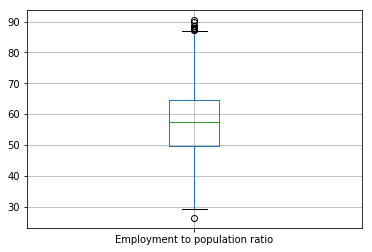

In [26]:
WDIStats_pd.boxplot(column=['Employment to population ratio'])

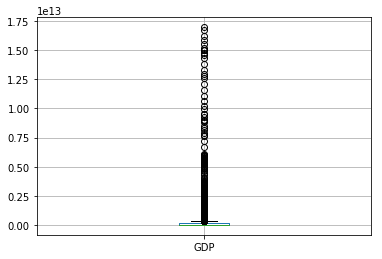

In [27]:
WDIStats_pd.boxplot(column=['GDP'])

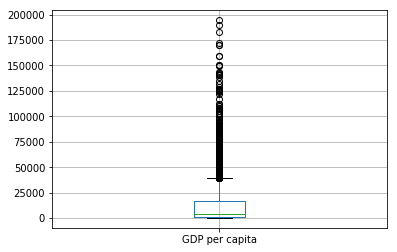

In [28]:
WDIStats_pd.boxplot(column=['GDP per capita'])

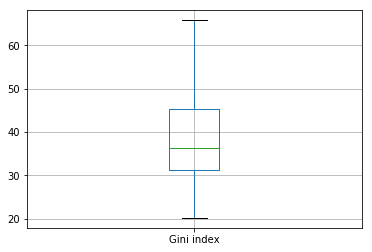

In [29]:
WDIStats_pd.boxplot(column=['Gini index'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f900cc13e48>,
      dtype=object)

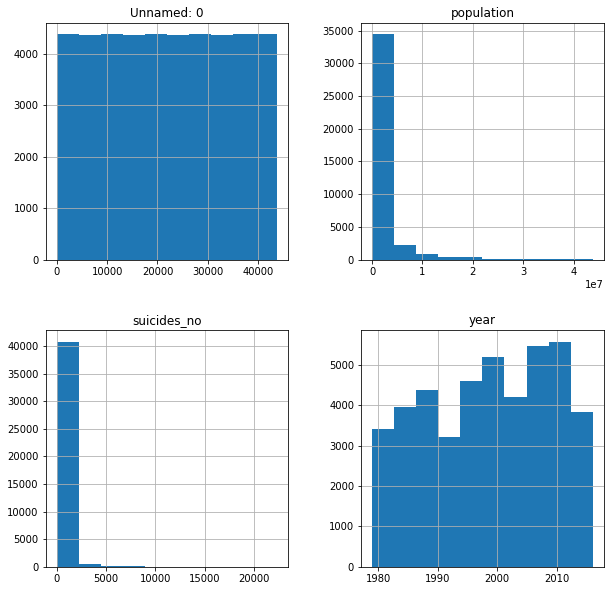

In [30]:
#Explore the data pattern of the dataset WHO Suicide Statistics
SuicideStats_pd.hist(figsize=(10, 10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f900cc76a90>,
      dtype=object)

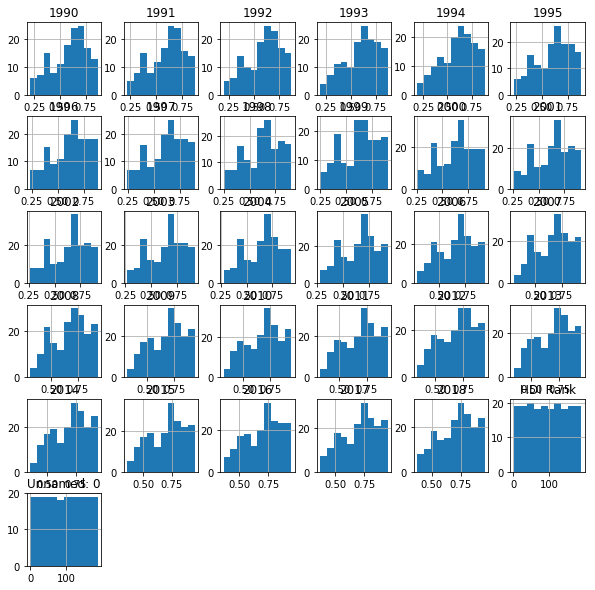

In [31]:
#Explore the data pattern of the dataset Human Development Index
HDIStats_pd.hist(figsize=(10, 10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f900c302c50>,
      dtype=object)

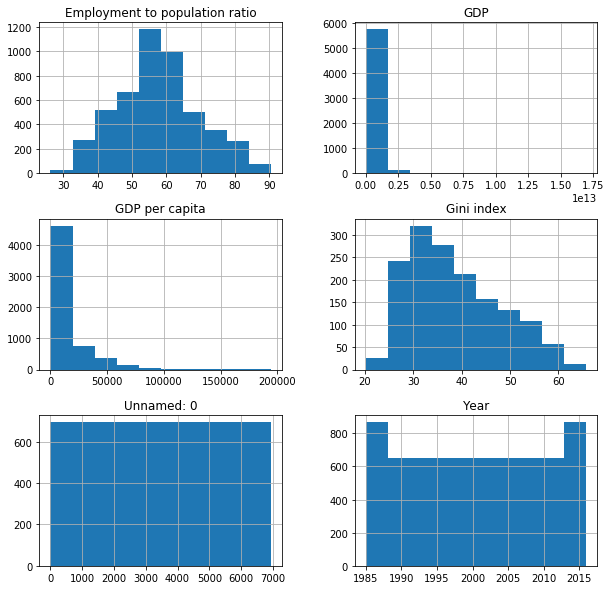

In [32]:
#Explore the data pattern of the dataset World Development Indicators
WDIStats_pd.hist(figsize=(10, 10))

In [33]:
#Data Manipulation

#Selecting Items
#select records with populartion greater than 0
print((SuicideStats.count(), len(SuicideStats.columns)))

SuicideStats.createOrReplaceTempView('suicideStats')
SuicideStats = spark.sql("SELECT * FROM suicideStats WHERE population >= 0")
print((SuicideStats.count(), len(SuicideStats.columns)))

(43776, 6)
(38316, 6)


In [34]:
#remove HDI Rank from HDIStats
print((HDIStats.count(), len(HDIStats.columns)))

HDIStats = HDIStats.drop("HDI Rank")

print((HDIStats.count(), len(HDIStats.columns)))

(189, 31)
(189, 30)


In [35]:
HDIStats.show(6)

+-----------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|          Country| 1990| 1991| 1992| 1993| 1994| 1995| 1996| 1997| 1998| 1999| 2000| 2001| 2002| 2003| 2004| 2005| 2006| 2007| 2008| 2009| 2010| 2011| 2012| 2013| 2014| 2015| 2016| 2017| 2018|
+-----------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|      Afghanistan|0.298|0.304|0.312|0.308|0.303|0.327|0.331|0.335|0.339|0.343|0.345|0.347|0.378|0.387|  0.4| 0.41|0.419|0.431|0.436|0.447|0.464|0.465|0.479|0.485|0.488| 0.49|0.491|0.493|0.496|
|          Albania|0.644|0.625|0.608|0.611|0.617|0.629|0.639|0.639|0.649| 0.66|0.667|0.673| 0.68|0.687|0.692|0.702|0.709|0.718|0.724|0.729| 0.74|0.759|0.771|0.781|0.787|0.788|0.788|0.789|0.791|
|          Algeria|0.578|0.582

In [36]:
#Data cleaning
#remove misssing values from WHO Suicide Statistics
print((SuicideStats.count(), len(SuicideStats.columns)))
SuicideStats = SuicideStats.na.drop(subset="suicides_no")
print((SuicideStats.count(), len(SuicideStats.columns)))

#Display the number of null value in each column after removing missing values
SuicideStats.select([count(when(col(c).isNull(), c)).alias(c) for c in SuicideStats.columns]).show()

(38316, 6)
(36060, 6)
+-------+----+---+---+-----------+----------+
|country|year|sex|age|suicides_no|population|
+-------+----+---+---+-----------+----------+
|      0|   0|  0|  0|          0|         0|
+-------+----+---+---+-----------+----------+



In [37]:
#Calculate mean value of each country
HDIStatsMean = HDIStats.na.fill(0)
HDIStatsMean = HDIStatsMean.select(col('Country'), (sum(col(x) for x in HDIStats.columns[1:]) / len(HDIStats.columns)-1).alias("mean"))

HDIStatsMean.show(6)

+-----------------+--------------------+
|          Country|                mean|
+-----------------+--------------------+
|      Afghanistan| -0.6149666666666667|
|          Albania|-0.32346666666666657|
|          Algeria|              -0.346|
|          Andorra| -0.4764666666666667|
|           Angola| -0.6722333333333333|
|AntiguaandBarbuda|             -0.6392|
+-----------------+--------------------+
only showing top 6 rows



In [38]:
HDIStats = HDIStats.alias('a')\
    .join(HDIStatsMean.alias('b'),col('b.Country') == col('a.Country'))\
    .select([when(col('a.'+xx).isNull(), col('b.mean')).otherwise(col('a.'+xx)).alias(xx) for xx in HDIStats.columns])

#Display the number of null value in each column after removing missing values
HDIStats.select([count(when(col(c).isNull(), c)).alias(c) for c in HDIStats.columns]).show()


+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|Country|1990|1991|1992|1993|1994|1995|1996|1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|
+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|      0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|
+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+



In [39]:
#cleanig WDIStats
#replace missing value with the mean value of this country

WDIStats.select([count(when(col(c).isNull(), c)).alias(c) for c in WDIStats.columns]).show()

def fill_with_mean(df, exclude=set()): 
    stats = df.agg(*(
        avg(c).alias(c) for c in df.columns if c not in exclude
    ))
    return df.na.fill(stats.first().asDict())

WDIStats = fill_with_mean(WDIStats, ["Country Name", "Year"])

WDIStats.select([count(when(col(c).isNull(), c)).alias(c) for c in WDIStats.columns]).show()

+------------+----+------------------------------+---+--------------+----------+
|Country Name|Year|Employment to population ratio|GDP|GDP per capita|Gini index|
+------------+----+------------------------------+---+--------------+----------+
|           0|   0|                          2082|965|           968|      5394|
+------------+----+------------------------------+---+--------------+----------+

+------------+----+------------------------------+---+--------------+----------+
|Country Name|Year|Employment to population ratio|GDP|GDP per capita|Gini index|
+------------+----+------------------------------+---+--------------+----------+
|           0|   0|                             0|  0|             0|         0|
+------------+----+------------------------------+---+--------------+----------+



In [40]:
#remove extreme and outliers
print((SuicideStats.count(), len(SuicideStats.columns)))

bounds = {
    c: dict(
        zip(["q1", "q3"], SuicideStats.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in SuicideStats.columns if c in ["suicides_no", "population"]
}

for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)

SuicideStats = SuicideStats.select(
    "*",
    *[
        when(
            col(c).between(bounds[c]['lower'], bounds[c]['upper']),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in SuicideStats.columns  if c in ["suicides_no", "population"]
    ]
)

SuicideStats.createOrReplaceTempView('SuicideStats')
SuicideStats = spark.sql("SELECT country, year, sex, age, suicides_no, population FROM SuicideStats WHERE suicides_no_out = 0 and population_out=0 ")
print((SuicideStats.count(), len(SuicideStats.columns)))


(36060, 6)
(28783, 6)


In [41]:
#Construct the Data
#add new feature suicidePer100k to SuicideStats

SuicideStats = SuicideStats.withColumn("SuicidePer100k", col("suicides_no")/col("population")*100000)

print((SuicideStats.count(), len(SuicideStats.columns)))
SuicideStats.show(6)

(28783, 7)
+-------+----+------+-----------+-----------+----------+------------------+
|country|year|   sex|        age|suicides_no|population|    SuicidePer100k|
+-------+----+------+-----------+-----------+----------+------------------+
|Albania|1987|female|15-24 years|         14|    289700|4.8325854332067655|
|Albania|1987|female|25-34 years|          4|    257200|1.5552099533437014|
|Albania|1987|female|35-54 years|          6|    278800|2.1520803443328553|
|Albania|1987|female| 5-14 years|          0|    311000|               0.0|
|Albania|1987|female|55-74 years|          0|    144600|               0.0|
|Albania|1987|female|  75+ years|          1|     35600| 2.808988764044944|
+-------+----+------+-----------+-----------+----------+------------------+
only showing top 6 rows



In [42]:
#transport HDI score 
#HDIStats.columns
HDIStats.show(3)

cols, dtypes = zip(*((c, t) for (c, t) in HDIStats.dtypes if c not in ['Country']))
kvs = explode(array([
      struct(lit(c).alias("Year"), col(c).alias("HDIScore")) for c in cols
    ])).alias("kvs")
    
HDIStats = HDIStats.select(['Country'] + [kvs]).select(['Country'] + ["kvs.Year", "kvs.HDIScore"])
HDIStats.show(6)


+-----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|    Country| 1990| 1991| 1992| 1993| 1994| 1995| 1996| 1997| 1998| 1999| 2000| 2001| 2002| 2003| 2004| 2005| 2006| 2007| 2008| 2009| 2010| 2011| 2012| 2013| 2014| 2015| 2016| 2017| 2018|
+-----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|Afghanistan|0.298|0.304|0.312|0.308|0.303|0.327|0.331|0.335|0.339|0.343|0.345|0.347|0.378|0.387|  0.4| 0.41|0.419|0.431|0.436|0.447|0.464|0.465|0.479|0.485|0.488| 0.49|0.491|0.493|0.496|
|    Albania|0.644|0.625|0.608|0.611|0.617|0.629|0.639|0.639|0.649| 0.66|0.667|0.673| 0.68|0.687|0.692|0.702|0.709|0.718|0.724|0.729| 0.74|0.759|0.771|0.781|0.787|0.788|0.788|0.789|0.791|
|    Algeria|0.578|0.582|0.589|0.593|0.597|0.602| 0.61|0.619

In [43]:
#Integrate Data Sources

#rename columns
SuicideStats = SuicideStats.withColumnRenamed("country","Country")\
    .withColumnRenamed("year","Year")\
    .withColumnRenamed("sex","Sex")\
    .withColumnRenamed("age","Age")\
    .withColumnRenamed("suicides_no","SuicidesNo")\
    .withColumnRenamed("population","Population")

WDIStats = WDIStats.withColumnRenamed("Country Name","Country")\
    .withColumnRenamed("Employment to population ratio","EmploymentToPopulationRatio")\
    .withColumnRenamed("GDP per capita","GDPPerCapita")\
    .withColumnRenamed("Gini index","GiniIndex")


In [44]:
#merge data to a single data frame
datasource = SuicideStats\
    .join(HDIStats, (SuicideStats.Country == HDIStats.Country) & (SuicideStats.Year == HDIStats.Year))\
    .join(WDIStats, (SuicideStats.Country == WDIStats.Country) & (SuicideStats.Year == WDIStats.Year))\
    .select([SuicideStats.Country, SuicideStats.Year, SuicideStats.Sex, SuicideStats.Age, SuicideStats.SuicidesNo,
             SuicideStats.Population, SuicideStats.SuicidePer100k, HDIStats.HDIScore,
             WDIStats.EmploymentToPopulationRatio, WDIStats.GDP, WDIStats.GDPPerCapita, WDIStats.GiniIndex])

print((datasource.count(), len(datasource.columns)))
datasource.show(6)

(17665, 12)
+-------+----+----+-----------+----------+----------+------------------+--------+---------------------------+-------------+------------+-----------------+
|Country|Year| Sex|        Age|SuicidesNo|Population|    SuicidePer100k|HDIScore|EmploymentToPopulationRatio|          GDP|GDPPerCapita|        GiniIndex|
+-------+----+----+-----------+----------+----------+------------------+--------+---------------------------+-------------+------------+-----------------+
|Albania|1992|male|  75+ years|         0|     23900|               0.0|   0.608|                54.30599976|4.038036613E9| 1243.605824|38.62148387096775|
|Albania|1992|male|55-74 years|         5|    159500| 3.134796238244514|   0.608|                54.30599976|4.038036613E9| 1243.605824|38.62148387096775|
|Albania|1992|male| 5-14 years|         0|    362900|               0.0|   0.608|                54.30599976|4.038036613E9| 1243.605824|38.62148387096775|
|Albania|1992|male|35-54 years|        12|    343800|3.490

In [45]:
datasource.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SuicidesNo: integer (nullable = true)
 |-- Population: integer (nullable = true)
 |-- SuicidePer100k: double (nullable = true)
 |-- HDIScore: double (nullable = true)
 |-- EmploymentToPopulationRatio: double (nullable = false)
 |-- GDP: double (nullable = false)
 |-- GDPPerCapita: double (nullable = false)
 |-- GiniIndex: double (nullable = false)



In [46]:
#drop some columns
datasource = datasource.drop('SuicidesNo')\
    .drop('Population')\
    .drop('Year')

datasource.columns

['Country',
 'Sex',
 'Age',
 'SuicidePer100k',
 'HDIScore',
 'EmploymentToPopulationRatio',
 'GDP',
 'GDPPerCapita',
 'GiniIndex']

In [47]:
datasource = datasource.withColumn('Sex',when(datasource.Sex == 'male', 0).otherwise(1))\
                .withColumn('Age',when(datasource.Age == '5-14 years', 5)\
                            .when(datasource.Age == '15-24 years', 15)\
                            .when(datasource.Age == '25-34 years', 25)\
                            .when(datasource.Age == '35-54 years', 35)\
                            .when(datasource.Age == '55-74 years', 55).otherwise(75))
datasource.show(6)

+-------+---+---+------------------+--------+---------------------------+-------------+------------+-----------------+
|Country|Sex|Age|    SuicidePer100k|HDIScore|EmploymentToPopulationRatio|          GDP|GDPPerCapita|        GiniIndex|
+-------+---+---+------------------+--------+---------------------------+-------------+------------+-----------------+
|Albania|  0| 75|               0.0|   0.608|                54.30599976|4.038036613E9| 1243.605824|38.62148387096775|
|Albania|  0| 55| 3.134796238244514|   0.608|                54.30599976|4.038036613E9| 1243.605824|38.62148387096775|
|Albania|  0|  5|               0.0|   0.608|                54.30599976|4.038036613E9| 1243.605824|38.62148387096775|
|Albania|  0| 35|3.4904013961605584|   0.608|                54.30599976|4.038036613E9| 1243.605824|38.62148387096775|
|Albania|  0| 25|2.8513238289205702|   0.608|                54.30599976|4.038036613E9| 1243.605824|38.62148387096775|
|Albania|  0| 15|3.4129692832764507|   0.608|   

In [48]:
datasource.write.mode("overwrite").csv('ModelDataSource.csv')
datasource_pd = pd.read_csv("ModelDataSource.csv")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f900ce18860>,
      dtype=object)

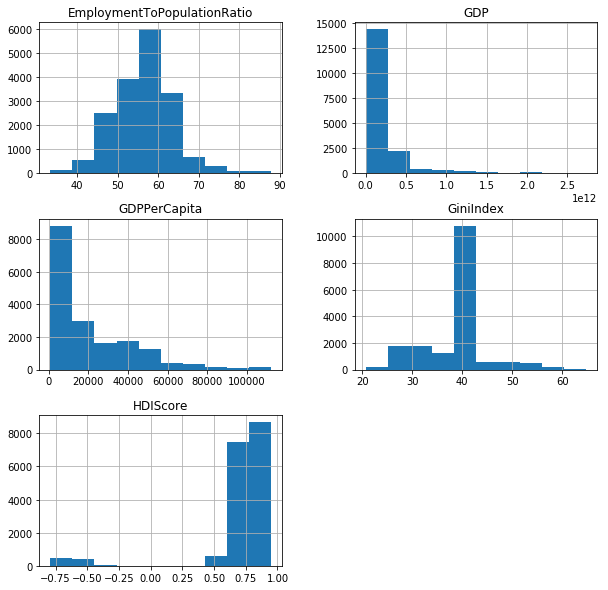

In [49]:
#Project the data
datasource_pd.hist(figsize=(10, 10), column=['HDIScore', 'EmploymentToPopulationRatio', 'GDP',
 'GDPPerCapita', 'GiniIndex'])

In [50]:
datasource = datasource.withColumn("LogGDPPerCapita", log("GDPPerCapita")).withColumn("LogGDP", log("GDP"))

datasource.write.mode("overwrite").csv('ModelDataSource.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f900c102da0>,
      dtype=object)

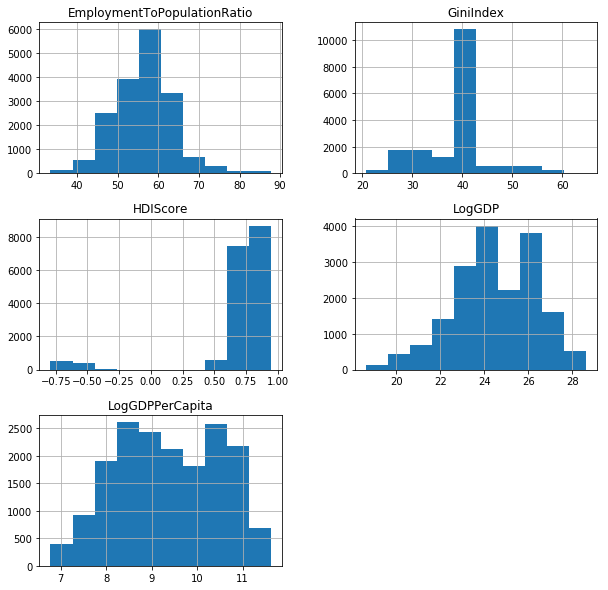

In [51]:
datasource_pd = pd.read_csv("ModelDataSource.csv")
datasource_pd.hist(figsize=(10, 10), column=['HDIScore', 'EmploymentToPopulationRatio', 'LogGDP',
 'LogGDPPerCapita', 'GiniIndex'])

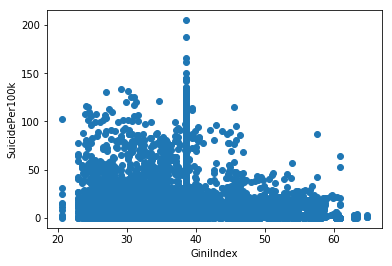

In [52]:
plt.scatter(datasource_pd.GiniIndex, datasource_pd.SuicidePer100k)
plt.xlabel("GiniIndex")
plt.ylabel("SuicidePer100k")
plt.show()

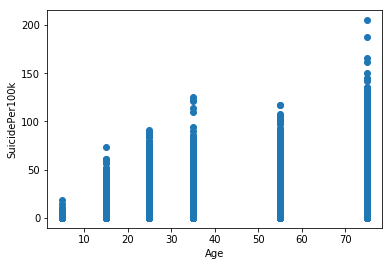

In [53]:
plt.scatter(datasource_pd.Age, datasource_pd.SuicidePer100k)
plt.xlabel("Age")
plt.ylabel("SuicidePer100k")
plt.show()

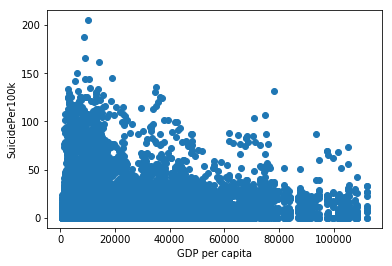

In [54]:
plt.scatter(datasource_pd.GDPPerCapita, datasource_pd.SuicidePer100k)
plt.xlabel("GDP per capita")
plt.ylabel("SuicidePer100k")
plt.show()

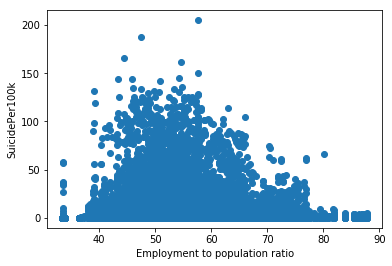

In [55]:
plt.scatter(datasource_pd.EmploymentToPopulationRatio, datasource_pd.SuicidePer100k)
plt.xlabel("Employment to population ratio")
plt.ylabel("SuicidePer100k")
plt.show()

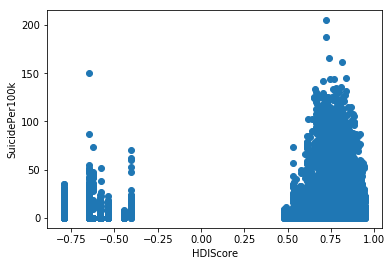

In [56]:
plt.scatter(datasource_pd.HDIScore, datasource_pd.SuicidePer100k)
plt.xlabel("HDIScore")
plt.ylabel("SuicidePer100k")
plt.show()

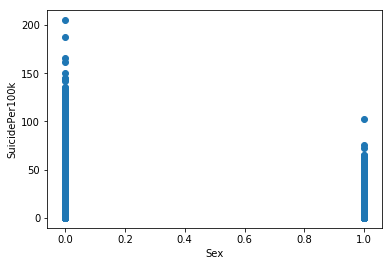

In [57]:
plt.scatter(datasource_pd.Sex, datasource_pd.SuicidePer100k)
plt.xlabel("Sex")
plt.ylabel("SuicidePer100k")
plt.show()

In [59]:
#Train and Test Split
# Split the data
(train, test) = datasource.randomSplit([0.7, 0.3], seed =722)
print("The size of dataset is: ",(datasource.count(), len(datasource.columns)))
print("The size of training data is: ", (train.count(), len(train.columns)))
print("The size of test data is: ", (test.count(), len(test.columns)))

The size of dataset is:  (17665, 11)
The size of training data is:  (12335, 11)


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 1035, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 883, in send_command
    response = connection.send_command(command)
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 1040, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/IPython/core/int

Py4JError: An error occurred while calling o1268.count

In [ ]:
# casts all columns to a numeric type
sexIndexer = StringIndexer(inputCol="Sex", outputCol="SexIndex")
ageIndexer = StringIndexer(inputCol="Age", outputCol="AgeIndex")

In [ ]:
featuresCols = ['HDIScore', 'EmploymentToPopulationRatio', 'LogGDPPerCapita', 'LogGDP', 'GiniIndex', 'SexIndex', 'AgeIndex']
featureAssembler = VectorAssembler(inputCols=featuresCols, outputCol="rawFeatures")
featureIndexer = VectorIndexer(inputCol="rawFeatures", outputCol="indexedFeatures", maxCategories=5)

In [ ]:
# Takes the "features" column and learns to predict "SuicidePer100k"
gbt = GBTRegressor(featuresCol="indexedFeatures",labelCol="SuicidePer100k", maxIter=5, maxDepth=8)


In [ ]:
pipeline = Pipeline(stages=[sexIndexer, ageIndexer, featureAssembler, featureIndexer, gbt])

pipelineModel = pipeline.fit(train)

In [ ]:
predictions = pipelineModel.transform(test)
display(predictions.select("SuicidePer100k", "prediction", *featuresCols))

In [ ]:
evaluator = RegressionEvaluator(
    labelCol="SuicidePer100k", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

In [ ]:
gbtModel = pipelineModel.stages[-1]

In [ ]:
gbtModel.featureImportances

In [ ]:
predictions_df = predictions.toPandas()

In [ ]:
plt.scatter(predictions_df.prediction, predictions_df.SuicidePer100k)
plt.title("predict vs test (max_depth:8)")
plt.xlabel("predict")
plt.ylabel("test")
plt.show()